# Github respository: meteorite-landings

Three hundred and forty-three active DCA are defined
to date, containing a total of 67,222 meteorites. The
average number of meteorites per DCA is 196 meteorites.
The median number of meteorites per DCA is four only,
reflecting a very uneven distribution of meteorites among
DCA. Only 37 DCA contain more than 100 meteorites,
and the 23 most populated DCA (most of them in
Antarctica) contain 90% of the total DCA meteorites. A
full list of all approved DCAs, with maps, can be found at
https://www.lpi.usra.edu/meteor/DenseAreas.php.

In [38]:
REFRESH_DATA = True

import numpy as np
import pandas as pd
import datetime
import os

if REFRESH_DATA:
    # pip install python-dotenv
    # pip install sodapy
    # pip install reverse_geocoder
    from dotenv import load_dotenv
    from sodapy import Socrata
    import reverse_geocoder as rg
    import json
    

In [39]:
if REFRESH_DATA:

    # Load .env file using:
    load_dotenv()

    # Obtain environment variables:
    APP_TOKEN = os.getenv("APP_TOKEN")


In [40]:
if REFRESH_DATA:

    # Unauthenticated client only works with public data sets. Note 'None'
    # in place of application token, and no username or password:
    # client = Socrata("data.nasa.gov", None)

    # Example authenticated client (needed for non-public datasets):
    client = Socrata("data.nasa.gov", APP_TOKEN)

    # Page through results, returned as JSON from API / converted to Python list of
    # dictionaries by sodapy.  This should get all entries (45,716 as of 2021-11-14)
    query_offset = 0
    query_limit = 2000
    query_active = True
    df_pages = []

    while query_active:          
        results = client.get("gh4g-9sfh", limit=query_limit, offset=query_offset)
        results_df = pd.DataFrame.from_records(results)
        df_pages.append(results_df)
        if len(results_df) < query_limit:
            query_active = False
        else:
            query_offset += query_limit

    # Convert to pandas DataFrame
    meteorite_data = pd.concat(df_pages, ignore_index=True)



In [41]:
if REFRESH_DATA:
    # Convert lat/long to floats
    meteorite_data['reclong'] = meteorite_data['reclong'].astype(float)
    meteorite_data['reclat'] = meteorite_data['reclat'].astype(float)
    
    # Drop data with missing lat/long values.
    print(meteorite_data.shape)
    meteorite_date = meteorite_data.dropna(subset=['reclong', 'reclat'], inplace=True)
    print(meteorite_data.shape)

    # Validate lat/long values.  Lat values should be -90 to 90; Long values should be -180 to 180.
    print(meteorite_data.shape)
    invalid_coords = (meteorite_data['reclong'] < -180) | (meteorite_data['reclong'] > 180) | (meteorite_data['reclat'] < -90) | (meteorite_data['reclat'] > 90)

    print(meteorite_data[invalid_coords].shape)
    rows_to_drop = meteorite_data[invalid_coords].index
    meteorite_data.drop(rows_to_drop, inplace=True)

    print(meteorite_data.shape)

(45716, 12)
(38401, 12)
(38401, 12)
(1, 12)
(38400, 12)


In [42]:
if REFRESH_DATA:

    country_names = pd.read_csv('country_codes.csv', header=None, index_col=1, squeeze=True, keep_default_na=False).to_dict()
    map_data = pd.DataFrame(columns = ['country_code', 'country_name', 'admin1', 'admin2'], index = meteorite_data.index)

    coordinates = tuple(zip(meteorite_data['reclat'], meteorite_data['reclong']))
    rg_result = rg.search(coordinates)

    for idx, result in enumerate(rg_result):
        result_parsed = {}
        result_parsed['country_code'] = result['cc']
        result_parsed['country_name'] = country_names[result['cc']]
        result_parsed['admin1'] = result['admin1']
        result_parsed['admin2'] = result['admin2']
        
        map_data.iloc[idx] = list(result_parsed.values())
     
meteorite_data = meteorite_data.join(map_data)

In [43]:
    # Drop extra geolocation columns
    meteorite_data.drop(['geolocation', ':@computed_region_cbhk_fwbd', ':@computed_region_nnqa_25f4'], axis=1, inplace=True)

    # Convert to CSV file
    meteorite_data.to_csv('meteorite-landings.csv')

### Data Loading and Cleaning

#### Load CSVs
Load the data from the csv files and run a quick review of the data for validity checks

In [44]:
meteorite_data = pd.read_csv('meteorite-landings.csv', index_col=0)
meteorite_data.head(15)

,name,id,nametype,recclass,mass,fall,year,reclat,reclong,country_code,country_name,admin1,admin2
0,Aachen,1,Valid,L5,21.0,Fell,1880-01-01T00:00:00.000,50.77500,6.08333,DE,Germany,North Rhine-Westphalia,Regierungsbezirk Koln
1,Aarhus,2,Valid,H6,720.0,Fell,1951-01-01T00:00:00.000,56.18333,10.23333,DK,Denmark,Central Jutland,Arhus Kommune
2,Abee,6,Valid,EH4,107000.0,Fell,1952-01-01T00:00:00.000,54.21667,-113.00000,CA,Canada,Alberta,NaN
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976-01-01T00:00:00.000,16.88333,-99.90000,MX,Mexico,Guerrero,NaN
4,Achiras,370,Valid,L6,780.0,Fell,1902-01-01T00:00:00.000,-33.16667,-64.95000,AR,Argentina,Cordoba,NaN
5,Adhi Kot,379,Valid,EH4,4239.0,Fell,1919-01-01T00:00:00.000,32.10000,71.80000,PK,Pakistan,Punjab,NaN
6,Adzhi-Bogdo (stone),390,Valid,LL3-6,910.0,Fell,1949-01-01T00:00:00.000,44.83333,95.16667,MN,Mongolia,Govi-Altay,NaN
7,Agen,392,Valid,H5,30000.0,Fell,1814-01-01T00:00:00.000,44.21667,0.61667,FR,France,Aquitaine,Departement du Lot-et-Garonne
8,Aguada,398,Valid,L6,1620.0,Fell,1930-01-01T00:00:00.000,-31.60000,-65.23333,AR,Argentina,Cordoba,NaN
9,Aguila Blanca,417,Valid,L,1440.0,Fell,1920-01-01T00:00:00.000,-30.86667,-64.55000,AR,Argentina,Cordoba,NaN


In [45]:
# Quick review of Meteorite data
print(meteorite_data.shape)
print(meteorite_data.info())
print(meteorite_data.isna().sum())

(38400, 13)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38400 entries, 0 to 45715
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          38400 non-null  object 
 1   id            38400 non-null  int64  
 2   nametype      38400 non-null  object 
 3   recclass      38400 non-null  object 
 4   mass          38282 non-null  float64
 5   fall          38400 non-null  object 
 6   year          38222 non-null  object 
 7   reclat        38400 non-null  float64
 8   reclong       38400 non-null  float64
 9   country_code  38379 non-null  object 
 10  country_name  38400 non-null  object 
 11  admin1        26461 non-null  object 
 12  admin2        9706 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 4.1+ MB
None
name                0
id                  0
nametype            0
recclass            0
mass              118
fall                0
year              178
reclat       

####  Clean Types
Clean up some data types and columns

In [46]:
# The id column looks like a good choice for an index.  Let's make sure it's unique.
print('Rows: ', meteorite_data.shape[0])
print('Unique ids: ', meteorite_data['id'].nunique())

# Looks good.  Let's make id the index.
meteorite_data.set_index('id', inplace=True)
meteorite_data.head()

Rows:  38400
Unique ids:  38400


,name,nametype,recclass,mass,fall,year,reclat,reclong,country_code,country_name,admin1,admin2
id,,,,,,,,,,,,
1,Aachen,Valid,L5,21.0,Fell,1880-01-01T00:00:00.000,50.77500,6.08333,DE,Germany,North Rhine-Westphalia,Regierungsbezirk Koln
2,Aarhus,Valid,H6,720.0,Fell,1951-01-01T00:00:00.000,56.18333,10.23333,DK,Denmark,Central Jutland,Arhus Kommune
6,Abee,Valid,EH4,107000.0,Fell,1952-01-01T00:00:00.000,54.21667,-113.00000,CA,Canada,Alberta,NaN
10,Acapulco,Valid,Acapulcoite,1914.0,Fell,1976-01-01T00:00:00.000,16.88333,-99.90000,MX,Mexico,Guerrero,NaN
370,Achiras,Valid,L6,780.0,Fell,1902-01-01T00:00:00.000,-33.16667,-64.95000,AR,Argentina,Cordoba,NaN


In [47]:
# The year is a string that is formateted as a date time.  We will just extract the year as the first four characters.
# First let's see if any values will be hard to deal with
print(meteorite_data['year'].isna().sum())  ## There are 178 NaN values we will need to handle

# Confirming the month, day, time is always Jan 1, midnight, and we can just strip the year
# print(meteorite_data['year'].str[4:].nunique())
# meteorite_data['year'] = meteorite_data['year'].str[0:4]

# Alternatively, we can converte to datetime and grab the year
meteorite_data['year'] = meteorite_data['year'].apply(lambda x: datetime.datetime.fromisoformat(x).year if pd.notna(x) else np.nan)
meteorite_data['year'] = meteorite_data['year'].astype('Int64')
meteorite_data.head()

178


,name,nametype,recclass,mass,fall,year,reclat,reclong,country_code,country_name,admin1,admin2
id,,,,,,,,,,,,
1,Aachen,Valid,L5,21.0,Fell,1880,50.77500,6.08333,DE,Germany,North Rhine-Westphalia,Regierungsbezirk Koln
2,Aarhus,Valid,H6,720.0,Fell,1951,56.18333,10.23333,DK,Denmark,Central Jutland,Arhus Kommune
6,Abee,Valid,EH4,107000.0,Fell,1952,54.21667,-113.00000,CA,Canada,Alberta,NaN
10,Acapulco,Valid,Acapulcoite,1914.0,Fell,1976,16.88333,-99.90000,MX,Mexico,Guerrero,NaN
370,Achiras,Valid,L6,780.0,Fell,1902,-33.16667,-64.95000,AR,Argentina,Cordoba,NaN


Categorical data for this dataset is defined as follows:
 - nametype
   - Relict: objects that were once meteorites (meteoritic origin) but are now highly altered by weathering on Earth (dominantly composed of secondary minerals)
   - Valid: all other meteorites
 - recclass
   - See: https://craterexplorer.ca/meteorite-glossary/
 - fall
   - Fell: the delivery of a meteorite to Earth was witnessed, either by humans or their devices
   - Found: all other meteorites

In [48]:
# It looks like nametype, recclass, and fall are categories.  Let's check the values.
print(meteorite_data['nametype'].value_counts())
# print(meteorite_data['recclass'].value_counts())
print(meteorite_data['fall'].value_counts())

# Each is confirmed to be categorical.  We will update the dtypes.
meteorite_data['nametype'] = meteorite_data['nametype'].astype('category')
meteorite_data['recclass'] = meteorite_data['recclass'].astype('category')
meteorite_data['fall'] = meteorite_data['fall'].astype('category')
print(meteorite_data.info())


Valid     38330
Relict       70
Name: nametype, dtype: int64
Found    37303
Fell      1097
Name: fall, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 38400 entries, 1 to 30414
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   name          38400 non-null  object  
 1   nametype      38400 non-null  category
 2   recclass      38400 non-null  category
 3   mass          38282 non-null  float64 
 4   fall          38400 non-null  category
 5   year          38222 non-null  Int64   
 6   reclat        38400 non-null  float64 
 7   reclong       38400 non-null  float64 
 8   country_code  38379 non-null  object  
 9   country_name  38400 non-null  object  
 10  admin1        26461 non-null  object  
 11  admin2        9706 non-null   object  
dtypes: Int64(1), category(3), float64(3), object(5)
memory usage: 3.1+ MB
None


### Data Exploration

In [49]:
meteorite_data.head()

,name,nametype,recclass,mass,fall,year,reclat,reclong,country_code,country_name,admin1,admin2
id,,,,,,,,,,,,
1,Aachen,Valid,L5,21.0,Fell,1880,50.77500,6.08333,DE,Germany,North Rhine-Westphalia,Regierungsbezirk Koln
2,Aarhus,Valid,H6,720.0,Fell,1951,56.18333,10.23333,DK,Denmark,Central Jutland,Arhus Kommune
6,Abee,Valid,EH4,107000.0,Fell,1952,54.21667,-113.00000,CA,Canada,Alberta,NaN
10,Acapulco,Valid,Acapulcoite,1914.0,Fell,1976,16.88333,-99.90000,MX,Mexico,Guerrero,NaN
370,Achiras,Valid,L6,780.0,Fell,1902,-33.16667,-64.95000,AR,Argentina,Cordoba,NaN


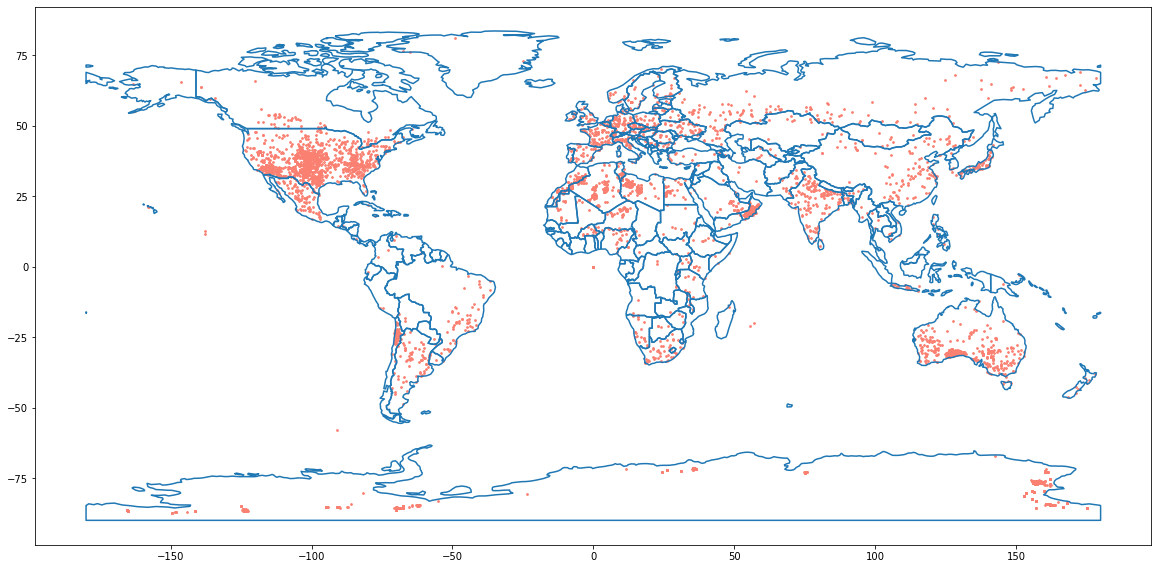

In [52]:
# Import visualization libraries
# pip install shapely
# pip install geopandas
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from IPython.display import display

geometry = [Point(xy) for xy in zip(meteorite_data['reclong'], meteorite_data['reclat'])]
gdf = GeoDataFrame(meteorite_data, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.boundary.plot(figsize=(20, 12)), marker='o', color='salmon', markersize=3);
